<a href="https://colab.research.google.com/github/Lukehsu1999/BraTS2025/blob/main/monai_3d_seg_BraTS_T7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](https://github.com/Project-MONAI/tutorials/blob/main/figures/spleen0.png?raw=1)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
 

## Setup imports

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.5.dev2519
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 552815d9e48a40cf72c7c718034df7984f5d14dd
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Wandb Logging

In [5]:
import wandb

# --- Configs from your WandB init ---
epochs = 600
lr = 1e-4
batch_size = 2
loss_func = "DiceLoss"
model = "3D UNet"

train_cnt, val_cnt = 17, 4

# --- WandB ---
run = wandb.init(
    project="BraTS",
    name="T7_mini_exp1",
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "model": model,
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukehsu1999 (luke-cmuh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp070bde3t


## Mount on Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set MSD Spleen dataset path

In [8]:
import glob
import os

data_dir = "/content/drive/MyDrive/BraTS_Task7_mini"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(data_dir, "**", "*t2f.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(data_dir, "**", "*seg_binary.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

# Manual split: last N for validation
train_files = data_dicts[:-4]  # adjust N based on your total case count
val_files   = data_dicts[-4:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

✅ Total cases: 21
📊 Training: 17  | Validation: 4


## Set deterministic training for reproducibility

In [9]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 96, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([90, 114, 71]), label shape: torch.Size([90, 114, 71])


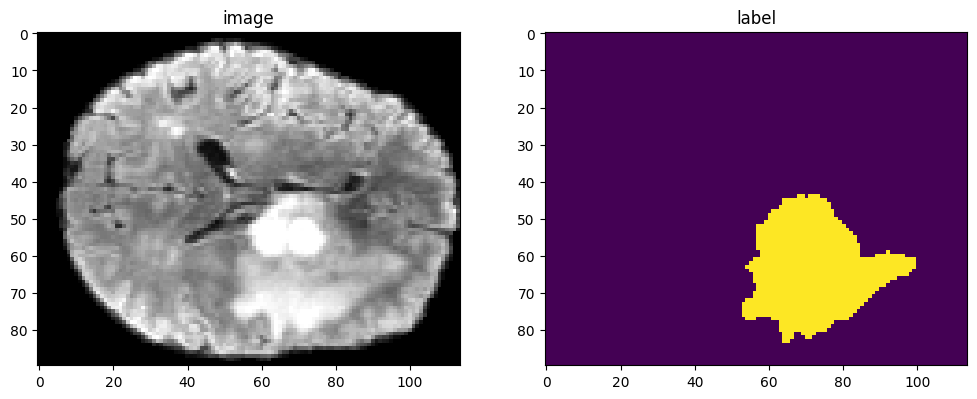

In [11]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 20]
idx = 40
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [12]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 17/17 [00:15<00:00,  1.13it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading dataset: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


## Create Model, Loss, Optimizer

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [14]:
from tqdm import tqdm, trange

In [15]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


epoch_range = trange(max_epochs, desc="Training Epochs")

for epoch in epoch_range:
    #print("-" * 10)
    #print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss, "epoch": epoch + 1})
    #print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)

            wandb.log({"val/dice": metric, "epoch": epoch + 1})
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            # print(
            #     f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            #     f"\nbest mean dice: {best_metric:.4f} "
            #     f"at epoch: {best_metric_epoch}"
            # )

Training Epochs:   0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training Epochs:   0%|          | 2/600 [00:12<1:00:40,  6.09s/it, loss=0.63]

saved new best metric model
current epoch: 2 current mean dice: 0.0920
best mean dice: 0.0920 at epoch: 2


Training Epochs:   1%|          | 4/600 [00:22<54:39,  5.50s/it, loss=0.603]

saved new best metric model
current epoch: 4 current mean dice: 0.1143
best mean dice: 0.1143 at epoch: 4


Training Epochs:   1%|          | 6/600 [00:32<53:34,  5.41s/it, loss=0.574]

saved new best metric model
current epoch: 6 current mean dice: 0.1421
best mean dice: 0.1421 at epoch: 6


Training Epochs:   1%|▏         | 8/600 [00:42<52:46,  5.35s/it, loss=0.566]

saved new best metric model
current epoch: 8 current mean dice: 0.1655
best mean dice: 0.1655 at epoch: 8


Training Epochs:   2%|▏         | 10/600 [00:53<54:13,  5.51s/it, loss=0.547]

saved new best metric model
current epoch: 10 current mean dice: 0.1700
best mean dice: 0.1700 at epoch: 10


Training Epochs:   2%|▏         | 12/600 [01:04<52:39,  5.37s/it, loss=0.536]

saved new best metric model
current epoch: 12 current mean dice: 0.1876
best mean dice: 0.1876 at epoch: 12


Training Epochs:   2%|▏         | 14/600 [01:14<51:27,  5.27s/it, loss=0.529]

saved new best metric model
current epoch: 14 current mean dice: 0.2023
best mean dice: 0.2023 at epoch: 14


Training Epochs:   3%|▎         | 16/600 [01:24<51:59,  5.34s/it, loss=0.52]

saved new best metric model
current epoch: 16 current mean dice: 0.2546
best mean dice: 0.2546 at epoch: 16


Training Epochs:   3%|▎         | 18/600 [01:34<50:48,  5.24s/it, loss=0.517]

saved new best metric model
current epoch: 18 current mean dice: 0.2883
best mean dice: 0.2883 at epoch: 18


Training Epochs:   3%|▎         | 20/600 [01:45<50:48,  5.26s/it, loss=0.492]

current epoch: 20 current mean dice: 0.2715
best mean dice: 0.2883 at epoch: 18


Training Epochs:   4%|▎         | 22/600 [01:55<50:50,  5.28s/it, loss=0.498]

saved new best metric model
current epoch: 22 current mean dice: 0.3747
best mean dice: 0.3747 at epoch: 22


Training Epochs:   4%|▍         | 24/600 [02:05<51:15,  5.34s/it, loss=0.485]

saved new best metric model
current epoch: 24 current mean dice: 0.4347
best mean dice: 0.4347 at epoch: 24


Training Epochs:   4%|▍         | 26/600 [02:16<50:40,  5.30s/it, loss=0.484]

saved new best metric model
current epoch: 26 current mean dice: 0.5654
best mean dice: 0.5654 at epoch: 26


Training Epochs:   5%|▍         | 28/600 [02:26<49:42,  5.21s/it, loss=0.47]

current epoch: 28 current mean dice: 0.5235
best mean dice: 0.5654 at epoch: 26


Training Epochs:   5%|▌         | 30/600 [02:36<50:01,  5.27s/it, loss=0.459]

current epoch: 30 current mean dice: 0.5134
best mean dice: 0.5654 at epoch: 26


Training Epochs:   5%|▌         | 32/600 [02:46<50:09,  5.30s/it, loss=0.444]

current epoch: 32 current mean dice: 0.4521
best mean dice: 0.5654 at epoch: 26


Training Epochs:   6%|▌         | 34/600 [02:57<51:45,  5.49s/it, loss=0.448]

saved new best metric model
current epoch: 34 current mean dice: 0.5747
best mean dice: 0.5747 at epoch: 34


Training Epochs:   6%|▌         | 36/600 [03:07<49:23,  5.25s/it, loss=0.452]

current epoch: 36 current mean dice: 0.3724
best mean dice: 0.5747 at epoch: 34


Training Epochs:   6%|▋         | 38/600 [03:17<48:40,  5.20s/it, loss=0.425]

current epoch: 38 current mean dice: 0.5101
best mean dice: 0.5747 at epoch: 34


Training Epochs:   7%|▋         | 40/600 [03:28<48:57,  5.25s/it, loss=0.431]

current epoch: 40 current mean dice: 0.5406
best mean dice: 0.5747 at epoch: 34


Training Epochs:   7%|▋         | 42/600 [03:38<48:48,  5.25s/it, loss=0.418]

current epoch: 42 current mean dice: 0.5492
best mean dice: 0.5747 at epoch: 34


Training Epochs:   7%|▋         | 44/600 [03:48<48:22,  5.22s/it, loss=0.416]

current epoch: 44 current mean dice: 0.4822
best mean dice: 0.5747 at epoch: 34


Training Epochs:   8%|▊         | 46/600 [03:58<48:36,  5.26s/it, loss=0.398]

current epoch: 46 current mean dice: 0.5263
best mean dice: 0.5747 at epoch: 34


Training Epochs:   8%|▊         | 48/600 [04:08<48:21,  5.26s/it, loss=0.399]

current epoch: 48 current mean dice: 0.5048
best mean dice: 0.5747 at epoch: 34


Training Epochs:   8%|▊         | 50/600 [04:19<47:43,  5.21s/it, loss=0.385]

current epoch: 50 current mean dice: 0.4905
best mean dice: 0.5747 at epoch: 34


Training Epochs:   9%|▊         | 52/600 [04:29<47:50,  5.24s/it, loss=0.372]

current epoch: 52 current mean dice: 0.4296
best mean dice: 0.5747 at epoch: 34


Training Epochs:   9%|▉         | 54/600 [04:40<48:41,  5.35s/it, loss=0.373]

current epoch: 54 current mean dice: 0.4850
best mean dice: 0.5747 at epoch: 34


Training Epochs:   9%|▉         | 56/600 [04:50<48:03,  5.30s/it, loss=0.374]

current epoch: 56 current mean dice: 0.3881
best mean dice: 0.5747 at epoch: 34


Training Epochs:  10%|▉         | 58/600 [05:00<48:41,  5.39s/it, loss=0.37]

current epoch: 58 current mean dice: 0.4504
best mean dice: 0.5747 at epoch: 34


Training Epochs:  10%|█         | 60/600 [05:11<47:45,  5.31s/it, loss=0.374]

current epoch: 60 current mean dice: 0.4399
best mean dice: 0.5747 at epoch: 34


Training Epochs:  10%|█         | 62/600 [05:21<48:25,  5.40s/it, loss=0.328]

current epoch: 62 current mean dice: 0.4241
best mean dice: 0.5747 at epoch: 34


Training Epochs:  11%|█         | 64/600 [05:31<47:02,  5.27s/it, loss=0.33]

current epoch: 64 current mean dice: 0.4981
best mean dice: 0.5747 at epoch: 34


Training Epochs:  11%|█         | 66/600 [05:41<46:14,  5.20s/it, loss=0.333]

current epoch: 66 current mean dice: 0.4639
best mean dice: 0.5747 at epoch: 34


Training Epochs:  11%|█▏        | 68/600 [05:52<46:10,  5.21s/it, loss=0.322]

current epoch: 68 current mean dice: 0.4748
best mean dice: 0.5747 at epoch: 34


Training Epochs:  12%|█▏        | 70/600 [06:02<46:39,  5.28s/it, loss=0.318]

current epoch: 70 current mean dice: 0.5128
best mean dice: 0.5747 at epoch: 34


Training Epochs:  12%|█▏        | 72/600 [06:12<46:36,  5.30s/it, loss=0.322]

current epoch: 72 current mean dice: 0.5581
best mean dice: 0.5747 at epoch: 34


Training Epochs:  12%|█▏        | 74/600 [06:23<46:17,  5.28s/it, loss=0.298]

current epoch: 74 current mean dice: 0.4535
best mean dice: 0.5747 at epoch: 34


Training Epochs:  13%|█▎        | 76/600 [06:33<45:58,  5.26s/it, loss=0.289]

current epoch: 76 current mean dice: 0.4567
best mean dice: 0.5747 at epoch: 34


Training Epochs:  13%|█▎        | 78/600 [06:43<45:11,  5.19s/it, loss=0.283]

current epoch: 78 current mean dice: 0.5216
best mean dice: 0.5747 at epoch: 34


Training Epochs:  13%|█▎        | 80/600 [06:53<44:42,  5.16s/it, loss=0.291]

current epoch: 80 current mean dice: 0.4980
best mean dice: 0.5747 at epoch: 34


Training Epochs:  14%|█▎        | 82/600 [07:03<44:47,  5.19s/it, loss=0.277]

current epoch: 82 current mean dice: 0.5286
best mean dice: 0.5747 at epoch: 34


Training Epochs:  14%|█▍        | 84/600 [07:14<45:28,  5.29s/it, loss=0.282]

current epoch: 84 current mean dice: 0.5484
best mean dice: 0.5747 at epoch: 34


Training Epochs:  14%|█▍        | 86/600 [07:25<47:08,  5.50s/it, loss=0.272]

current epoch: 86 current mean dice: 0.4303
best mean dice: 0.5747 at epoch: 34


Training Epochs:  15%|█▍        | 88/600 [07:35<45:08,  5.29s/it, loss=0.253]

current epoch: 88 current mean dice: 0.5678
best mean dice: 0.5747 at epoch: 34


Training Epochs:  15%|█▌        | 90/600 [07:45<45:01,  5.30s/it, loss=0.256]

saved new best metric model
current epoch: 90 current mean dice: 0.6049
best mean dice: 0.6049 at epoch: 90


Training Epochs:  15%|█▌        | 92/600 [07:55<45:12,  5.34s/it, loss=0.243]

current epoch: 92 current mean dice: 0.5458
best mean dice: 0.6049 at epoch: 90


Training Epochs:  16%|█▌        | 94/600 [08:06<45:15,  5.37s/it, loss=0.24]

current epoch: 94 current mean dice: 0.5274
best mean dice: 0.6049 at epoch: 90


Training Epochs:  16%|█▌        | 96/600 [08:17<45:16,  5.39s/it, loss=0.234]

current epoch: 96 current mean dice: 0.5835
best mean dice: 0.6049 at epoch: 90


Training Epochs:  16%|█▋        | 98/600 [08:27<44:39,  5.34s/it, loss=0.251]

current epoch: 98 current mean dice: 0.5134
best mean dice: 0.6049 at epoch: 90


Training Epochs:  17%|█▋        | 100/600 [08:37<43:44,  5.25s/it, loss=0.221]

current epoch: 100 current mean dice: 0.5436
best mean dice: 0.6049 at epoch: 90


Training Epochs:  17%|█▋        | 102/600 [08:47<42:22,  5.11s/it, loss=0.212]

current epoch: 102 current mean dice: 0.5846
best mean dice: 0.6049 at epoch: 90


Training Epochs:  17%|█▋        | 104/600 [08:57<43:18,  5.24s/it, loss=0.223]

current epoch: 104 current mean dice: 0.5963
best mean dice: 0.6049 at epoch: 90


Training Epochs:  18%|█▊        | 106/600 [09:08<44:16,  5.38s/it, loss=0.23]

current epoch: 106 current mean dice: 0.5533
best mean dice: 0.6049 at epoch: 90


Training Epochs:  18%|█▊        | 108/600 [09:18<44:17,  5.40s/it, loss=0.214]

current epoch: 108 current mean dice: 0.5972
best mean dice: 0.6049 at epoch: 90


Training Epochs:  18%|█▊        | 110/600 [09:28<42:50,  5.25s/it, loss=0.206]

current epoch: 110 current mean dice: 0.6034
best mean dice: 0.6049 at epoch: 90


Training Epochs:  19%|█▊        | 112/600 [09:39<42:46,  5.26s/it, loss=0.209]

saved new best metric model
current epoch: 112 current mean dice: 0.6473
best mean dice: 0.6473 at epoch: 112


Training Epochs:  19%|█▉        | 114/600 [09:49<43:33,  5.38s/it, loss=0.192]

current epoch: 114 current mean dice: 0.6382
best mean dice: 0.6473 at epoch: 112


Training Epochs:  19%|█▉        | 116/600 [10:00<43:30,  5.39s/it, loss=0.2]

saved new best metric model
current epoch: 116 current mean dice: 0.6497
best mean dice: 0.6497 at epoch: 116


Training Epochs:  20%|█▉        | 118/600 [10:10<43:11,  5.38s/it, loss=0.188]

current epoch: 118 current mean dice: 0.6376
best mean dice: 0.6497 at epoch: 116


Training Epochs:  20%|██        | 120/600 [10:21<42:40,  5.33s/it, loss=0.17]

saved new best metric model
current epoch: 120 current mean dice: 0.6700
best mean dice: 0.6700 at epoch: 120


Training Epochs:  20%|██        | 122/600 [10:31<42:46,  5.37s/it, loss=0.167]

current epoch: 122 current mean dice: 0.5800
best mean dice: 0.6700 at epoch: 120


Training Epochs:  21%|██        | 124/600 [10:41<41:14,  5.20s/it, loss=0.196]

current epoch: 124 current mean dice: 0.6496
best mean dice: 0.6700 at epoch: 120


Training Epochs:  21%|██        | 126/600 [10:51<41:35,  5.27s/it, loss=0.17]

current epoch: 126 current mean dice: 0.6146
best mean dice: 0.6700 at epoch: 120


Training Epochs:  21%|██▏       | 128/600 [11:02<41:43,  5.30s/it, loss=0.16]

current epoch: 128 current mean dice: 0.6522
best mean dice: 0.6700 at epoch: 120


Training Epochs:  22%|██▏       | 130/600 [11:12<41:25,  5.29s/it, loss=0.157]

current epoch: 130 current mean dice: 0.6113
best mean dice: 0.6700 at epoch: 120


Training Epochs:  22%|██▏       | 132/600 [11:22<40:41,  5.22s/it, loss=0.151]

current epoch: 132 current mean dice: 0.6435
best mean dice: 0.6700 at epoch: 120


Training Epochs:  22%|██▏       | 134/600 [11:33<40:53,  5.26s/it, loss=0.149]

current epoch: 134 current mean dice: 0.6628
best mean dice: 0.6700 at epoch: 120


Training Epochs:  23%|██▎       | 136/600 [11:43<41:31,  5.37s/it, loss=0.134]

current epoch: 136 current mean dice: 0.6256
best mean dice: 0.6700 at epoch: 120


Training Epochs:  23%|██▎       | 138/600 [11:53<40:42,  5.29s/it, loss=0.143]

current epoch: 138 current mean dice: 0.6353
best mean dice: 0.6700 at epoch: 120


Training Epochs:  23%|██▎       | 140/600 [12:03<39:39,  5.17s/it, loss=0.141]

current epoch: 140 current mean dice: 0.6074
best mean dice: 0.6700 at epoch: 120


Training Epochs:  24%|██▎       | 142/600 [12:13<39:40,  5.20s/it, loss=0.127]

current epoch: 142 current mean dice: 0.6663
best mean dice: 0.6700 at epoch: 120


Training Epochs:  24%|██▍       | 144/600 [12:24<40:31,  5.33s/it, loss=0.138]

current epoch: 144 current mean dice: 0.6395
best mean dice: 0.6700 at epoch: 120


Training Epochs:  24%|██▍       | 146/600 [12:34<40:11,  5.31s/it, loss=0.146]

current epoch: 146 current mean dice: 0.6530
best mean dice: 0.6700 at epoch: 120


Training Epochs:  25%|██▍       | 148/600 [12:45<40:07,  5.33s/it, loss=0.127]

current epoch: 148 current mean dice: 0.5077
best mean dice: 0.6700 at epoch: 120


Training Epochs:  25%|██▌       | 150/600 [12:55<39:31,  5.27s/it, loss=0.139]

saved new best metric model
current epoch: 150 current mean dice: 0.6996
best mean dice: 0.6996 at epoch: 150


Training Epochs:  25%|██▌       | 152/600 [13:05<39:27,  5.29s/it, loss=0.118]

current epoch: 152 current mean dice: 0.6495
best mean dice: 0.6996 at epoch: 150


Training Epochs:  26%|██▌       | 154/600 [13:15<38:43,  5.21s/it, loss=0.129]

current epoch: 154 current mean dice: 0.6810
best mean dice: 0.6996 at epoch: 150


Training Epochs:  26%|██▌       | 156/600 [13:26<38:33,  5.21s/it, loss=0.118]

current epoch: 156 current mean dice: 0.6298
best mean dice: 0.6996 at epoch: 150


Training Epochs:  26%|██▋       | 158/600 [13:36<39:00,  5.29s/it, loss=0.123]

current epoch: 158 current mean dice: 0.5102
best mean dice: 0.6996 at epoch: 150


Training Epochs:  27%|██▋       | 160/600 [13:46<38:49,  5.30s/it, loss=0.119]

current epoch: 160 current mean dice: 0.5952
best mean dice: 0.6996 at epoch: 150


Training Epochs:  27%|██▋       | 162/600 [13:56<37:40,  5.16s/it, loss=0.123]

current epoch: 162 current mean dice: 0.6551
best mean dice: 0.6996 at epoch: 150


Training Epochs:  27%|██▋       | 164/600 [14:07<38:11,  5.26s/it, loss=0.103]

current epoch: 164 current mean dice: 0.6787
best mean dice: 0.6996 at epoch: 150


Training Epochs:  28%|██▊       | 166/600 [14:17<38:51,  5.37s/it, loss=0.126]

current epoch: 166 current mean dice: 0.6901
best mean dice: 0.6996 at epoch: 150


Training Epochs:  28%|██▊       | 168/600 [14:28<38:37,  5.36s/it, loss=0.125]

current epoch: 168 current mean dice: 0.6451
best mean dice: 0.6996 at epoch: 150


Training Epochs:  28%|██▊       | 170/600 [14:39<39:16,  5.48s/it, loss=0.101]

current epoch: 170 current mean dice: 0.6264
best mean dice: 0.6996 at epoch: 150


Training Epochs:  29%|██▊       | 172/600 [14:49<38:26,  5.39s/it, loss=0.101]

current epoch: 172 current mean dice: 0.6449
best mean dice: 0.6996 at epoch: 150


Training Epochs:  29%|██▉       | 174/600 [15:00<38:36,  5.44s/it, loss=0.093]

current epoch: 174 current mean dice: 0.6662
best mean dice: 0.6996 at epoch: 150


Training Epochs:  29%|██▉       | 176/600 [15:10<37:43,  5.34s/it, loss=0.113]

current epoch: 176 current mean dice: 0.6192
best mean dice: 0.6996 at epoch: 150


Training Epochs:  30%|██▉       | 178/600 [15:20<36:52,  5.24s/it, loss=0.106]

current epoch: 178 current mean dice: 0.1434
best mean dice: 0.6996 at epoch: 150


Training Epochs:  30%|███       | 180/600 [15:30<36:50,  5.26s/it, loss=0.112]

current epoch: 180 current mean dice: 0.5843
best mean dice: 0.6996 at epoch: 150


Training Epochs:  30%|███       | 182/600 [15:41<37:26,  5.37s/it, loss=0.0995]

current epoch: 182 current mean dice: 0.5964
best mean dice: 0.6996 at epoch: 150


Training Epochs:  31%|███       | 184/600 [15:51<37:05,  5.35s/it, loss=0.11]

current epoch: 184 current mean dice: 0.6492
best mean dice: 0.6996 at epoch: 150


Training Epochs:  31%|███       | 186/600 [16:02<37:29,  5.43s/it, loss=0.0983]

current epoch: 186 current mean dice: 0.5900
best mean dice: 0.6996 at epoch: 150


Training Epochs:  31%|███▏      | 188/600 [16:13<37:05,  5.40s/it, loss=0.0962]

current epoch: 188 current mean dice: 0.5030
best mean dice: 0.6996 at epoch: 150


Training Epochs:  32%|███▏      | 190/600 [16:23<37:01,  5.42s/it, loss=0.094]

current epoch: 190 current mean dice: 0.5077
best mean dice: 0.6996 at epoch: 150


Training Epochs:  32%|███▏      | 192/600 [16:34<36:28,  5.36s/it, loss=0.097]

current epoch: 192 current mean dice: 0.5054
best mean dice: 0.6996 at epoch: 150


Training Epochs:  32%|███▏      | 194/600 [16:44<36:04,  5.33s/it, loss=0.121]

current epoch: 194 current mean dice: 0.4874
best mean dice: 0.6996 at epoch: 150


Training Epochs:  33%|███▎      | 196/600 [16:54<35:25,  5.26s/it, loss=0.0883]

current epoch: 196 current mean dice: 0.5480
best mean dice: 0.6996 at epoch: 150


Training Epochs:  33%|███▎      | 198/600 [17:04<35:04,  5.23s/it, loss=0.0931]

current epoch: 198 current mean dice: 0.5938
best mean dice: 0.6996 at epoch: 150


Training Epochs:  33%|███▎      | 200/600 [17:14<34:25,  5.16s/it, loss=0.0895]

current epoch: 200 current mean dice: 0.5294
best mean dice: 0.6996 at epoch: 150


Training Epochs:  34%|███▎      | 202/600 [17:25<34:50,  5.25s/it, loss=0.0911]

current epoch: 202 current mean dice: 0.6204
best mean dice: 0.6996 at epoch: 150


Training Epochs:  34%|███▍      | 204/600 [17:35<35:16,  5.35s/it, loss=0.0947]

current epoch: 204 current mean dice: 0.5928
best mean dice: 0.6996 at epoch: 150


Training Epochs:  34%|███▍      | 206/600 [17:46<35:05,  5.34s/it, loss=0.0804]

current epoch: 206 current mean dice: 0.6663
best mean dice: 0.6996 at epoch: 150


Training Epochs:  35%|███▍      | 208/600 [17:56<35:13,  5.39s/it, loss=0.0821]

current epoch: 208 current mean dice: 0.6361
best mean dice: 0.6996 at epoch: 150


Training Epochs:  35%|███▌      | 210/600 [18:07<34:58,  5.38s/it, loss=0.0827]

current epoch: 210 current mean dice: 0.6612
best mean dice: 0.6996 at epoch: 150


Training Epochs:  35%|███▌      | 212/600 [18:17<35:11,  5.44s/it, loss=0.0875]

current epoch: 212 current mean dice: 0.6251
best mean dice: 0.6996 at epoch: 150


Training Epochs:  36%|███▌      | 214/600 [18:28<34:27,  5.36s/it, loss=0.0799]

current epoch: 214 current mean dice: 0.6073
best mean dice: 0.6996 at epoch: 150


Training Epochs:  36%|███▌      | 216/600 [18:38<33:27,  5.23s/it, loss=0.0845]

current epoch: 216 current mean dice: 0.4954
best mean dice: 0.6996 at epoch: 150


Training Epochs:  36%|███▋      | 218/600 [18:48<33:23,  5.24s/it, loss=0.0778]

current epoch: 218 current mean dice: 0.5813
best mean dice: 0.6996 at epoch: 150


Training Epochs:  37%|███▋      | 220/600 [18:58<33:40,  5.32s/it, loss=0.0787]

current epoch: 220 current mean dice: 0.6244
best mean dice: 0.6996 at epoch: 150


Training Epochs:  37%|███▋      | 222/600 [19:09<33:46,  5.36s/it, loss=0.0789]

current epoch: 222 current mean dice: 0.6558
best mean dice: 0.6996 at epoch: 150


Training Epochs:  37%|███▋      | 224/600 [19:19<33:05,  5.28s/it, loss=0.0795]

current epoch: 224 current mean dice: 0.6668
best mean dice: 0.6996 at epoch: 150


Training Epochs:  38%|███▊      | 226/600 [19:29<32:40,  5.24s/it, loss=0.0757]

current epoch: 226 current mean dice: 0.6627
best mean dice: 0.6996 at epoch: 150


Training Epochs:  38%|███▊      | 228/600 [19:40<33:21,  5.38s/it, loss=0.0729]

current epoch: 228 current mean dice: 0.6677
best mean dice: 0.6996 at epoch: 150


Training Epochs:  38%|███▊      | 230/600 [19:50<32:45,  5.31s/it, loss=0.0744]

current epoch: 230 current mean dice: 0.6784
best mean dice: 0.6996 at epoch: 150


Training Epochs:  39%|███▊      | 232/600 [20:01<32:34,  5.31s/it, loss=0.074]

current epoch: 232 current mean dice: 0.6323
best mean dice: 0.6996 at epoch: 150


Training Epochs:  39%|███▉      | 234/600 [20:11<32:11,  5.28s/it, loss=0.0759]

current epoch: 234 current mean dice: 0.6601
best mean dice: 0.6996 at epoch: 150


Training Epochs:  39%|███▉      | 236/600 [20:21<31:37,  5.21s/it, loss=0.0766]

current epoch: 236 current mean dice: 0.5751
best mean dice: 0.6996 at epoch: 150


Training Epochs:  40%|███▉      | 238/600 [20:31<31:26,  5.21s/it, loss=0.0728]

current epoch: 238 current mean dice: 0.5906
best mean dice: 0.6996 at epoch: 150


Training Epochs:  40%|████      | 240/600 [20:41<31:18,  5.22s/it, loss=0.0766]

current epoch: 240 current mean dice: 0.6222
best mean dice: 0.6996 at epoch: 150


Training Epochs:  40%|████      | 242/600 [20:51<31:17,  5.24s/it, loss=0.0713]

current epoch: 242 current mean dice: 0.6421
best mean dice: 0.6996 at epoch: 150


Training Epochs:  41%|████      | 244/600 [21:02<31:09,  5.25s/it, loss=0.0708]

current epoch: 244 current mean dice: 0.6213
best mean dice: 0.6996 at epoch: 150


Training Epochs:  41%|████      | 246/600 [21:12<31:56,  5.41s/it, loss=0.074]

current epoch: 246 current mean dice: 0.5817
best mean dice: 0.6996 at epoch: 150


Training Epochs:  41%|████▏     | 248/600 [21:23<31:23,  5.35s/it, loss=0.0734]

current epoch: 248 current mean dice: 0.6503
best mean dice: 0.6996 at epoch: 150


Training Epochs:  42%|████▏     | 250/600 [21:34<31:43,  5.44s/it, loss=0.073]

current epoch: 250 current mean dice: 0.6210
best mean dice: 0.6996 at epoch: 150


Training Epochs:  42%|████▏     | 252/600 [21:44<30:48,  5.31s/it, loss=0.0713]

current epoch: 252 current mean dice: 0.6093
best mean dice: 0.6996 at epoch: 150


Training Epochs:  42%|████▏     | 254/600 [21:54<30:08,  5.23s/it, loss=0.0743]

current epoch: 254 current mean dice: 0.6384
best mean dice: 0.6996 at epoch: 150


Training Epochs:  43%|████▎     | 256/600 [22:04<30:31,  5.32s/it, loss=0.0981]

current epoch: 256 current mean dice: 0.6021
best mean dice: 0.6996 at epoch: 150


Training Epochs:  43%|████▎     | 258/600 [22:15<30:40,  5.38s/it, loss=0.0685]

current epoch: 258 current mean dice: 0.6525
best mean dice: 0.6996 at epoch: 150


Training Epochs:  43%|████▎     | 260/600 [22:25<29:58,  5.29s/it, loss=0.0697]

current epoch: 260 current mean dice: 0.6689
best mean dice: 0.6996 at epoch: 150


Training Epochs:  44%|████▎     | 262/600 [22:35<29:19,  5.21s/it, loss=0.0675]

current epoch: 262 current mean dice: 0.6864
best mean dice: 0.6996 at epoch: 150


Training Epochs:  44%|████▍     | 264/600 [22:45<29:02,  5.18s/it, loss=0.0703]

current epoch: 264 current mean dice: 0.6613
best mean dice: 0.6996 at epoch: 150


Training Epochs:  44%|████▍     | 266/600 [22:56<29:30,  5.30s/it, loss=0.0735]

current epoch: 266 current mean dice: 0.6610
best mean dice: 0.6996 at epoch: 150


Training Epochs:  45%|████▍     | 268/600 [23:06<29:17,  5.29s/it, loss=0.0689]

current epoch: 268 current mean dice: 0.6484
best mean dice: 0.6996 at epoch: 150


Training Epochs:  45%|████▌     | 270/600 [23:16<28:55,  5.26s/it, loss=0.0667]

current epoch: 270 current mean dice: 0.6525
best mean dice: 0.6996 at epoch: 150


Training Epochs:  45%|████▌     | 272/600 [23:26<28:32,  5.22s/it, loss=0.067]

current epoch: 272 current mean dice: 0.6482
best mean dice: 0.6996 at epoch: 150


Training Epochs:  46%|████▌     | 274/600 [23:37<28:24,  5.23s/it, loss=0.0653]

current epoch: 274 current mean dice: 0.6341
best mean dice: 0.6996 at epoch: 150


Training Epochs:  46%|████▌     | 276/600 [23:47<28:19,  5.24s/it, loss=0.0693]

current epoch: 276 current mean dice: 0.6211
best mean dice: 0.6996 at epoch: 150


Training Epochs:  46%|████▋     | 278/600 [23:57<28:10,  5.25s/it, loss=0.067]

current epoch: 278 current mean dice: 0.6685
best mean dice: 0.6996 at epoch: 150


Training Epochs:  47%|████▋     | 280/600 [24:08<28:25,  5.33s/it, loss=0.0657]

current epoch: 280 current mean dice: 0.6813
best mean dice: 0.6996 at epoch: 150


Training Epochs:  47%|████▋     | 282/600 [24:20<31:52,  6.01s/it, loss=0.0686]

current epoch: 282 current mean dice: 0.6274
best mean dice: 0.6996 at epoch: 150


Training Epochs:  47%|████▋     | 284/600 [24:31<29:56,  5.69s/it, loss=0.0713]

current epoch: 284 current mean dice: 0.6629
best mean dice: 0.6996 at epoch: 150


Training Epochs:  48%|████▊     | 286/600 [24:41<28:54,  5.53s/it, loss=0.0627]

current epoch: 286 current mean dice: 0.6703
best mean dice: 0.6996 at epoch: 150


Training Epochs:  48%|████▊     | 288/600 [24:52<28:14,  5.43s/it, loss=0.0664]

current epoch: 288 current mean dice: 0.6864
best mean dice: 0.6996 at epoch: 150


Training Epochs:  48%|████▊     | 290/600 [25:02<27:35,  5.34s/it, loss=0.0674]

current epoch: 290 current mean dice: 0.6643
best mean dice: 0.6996 at epoch: 150


Training Epochs:  49%|████▊     | 292/600 [25:12<26:53,  5.24s/it, loss=0.066]

current epoch: 292 current mean dice: 0.6425
best mean dice: 0.6996 at epoch: 150


Training Epochs:  49%|████▉     | 294/600 [25:22<26:47,  5.25s/it, loss=0.0648]

current epoch: 294 current mean dice: 0.6797
best mean dice: 0.6996 at epoch: 150


Training Epochs:  49%|████▉     | 296/600 [25:32<26:24,  5.21s/it, loss=0.0648]

current epoch: 296 current mean dice: 0.6315
best mean dice: 0.6996 at epoch: 150


Training Epochs:  50%|████▉     | 298/600 [25:42<25:54,  5.15s/it, loss=0.06]

current epoch: 298 current mean dice: 0.6431
best mean dice: 0.6996 at epoch: 150


Training Epochs:  50%|█████     | 300/600 [25:52<25:52,  5.18s/it, loss=0.0616]

current epoch: 300 current mean dice: 0.6284
best mean dice: 0.6996 at epoch: 150


Training Epochs:  50%|█████     | 302/600 [26:03<26:14,  5.28s/it, loss=0.0896]

current epoch: 302 current mean dice: 0.6635
best mean dice: 0.6996 at epoch: 150


Training Epochs:  51%|█████     | 304/600 [26:13<26:01,  5.28s/it, loss=0.0612]

current epoch: 304 current mean dice: 0.6850
best mean dice: 0.6996 at epoch: 150


Training Epochs:  51%|█████     | 306/600 [26:23<25:25,  5.19s/it, loss=0.0651]

current epoch: 306 current mean dice: 0.6304
best mean dice: 0.6996 at epoch: 150


Training Epochs:  51%|█████▏    | 308/600 [26:33<25:29,  5.24s/it, loss=0.0622]

current epoch: 308 current mean dice: 0.6535
best mean dice: 0.6996 at epoch: 150


Training Epochs:  52%|█████▏    | 310/600 [26:44<25:40,  5.31s/it, loss=0.0615]

current epoch: 310 current mean dice: 0.6521
best mean dice: 0.6996 at epoch: 150


Training Epochs:  52%|█████▏    | 312/600 [26:54<25:04,  5.23s/it, loss=0.0654]

current epoch: 312 current mean dice: 0.6877
best mean dice: 0.6996 at epoch: 150


Training Epochs:  52%|█████▏    | 314/600 [27:04<24:29,  5.14s/it, loss=0.0911]

current epoch: 314 current mean dice: 0.6296
best mean dice: 0.6996 at epoch: 150


Training Epochs:  53%|█████▎    | 316/600 [27:14<24:33,  5.19s/it, loss=0.0675]

current epoch: 316 current mean dice: 0.6511
best mean dice: 0.6996 at epoch: 150


Training Epochs:  53%|█████▎    | 318/600 [27:25<24:52,  5.29s/it, loss=0.0612]

current epoch: 318 current mean dice: 0.6477
best mean dice: 0.6996 at epoch: 150


Training Epochs:  53%|█████▎    | 320/600 [27:35<24:16,  5.20s/it, loss=0.0653]

current epoch: 320 current mean dice: 0.6485
best mean dice: 0.6996 at epoch: 150


Training Epochs:  54%|█████▎    | 322/600 [27:45<23:55,  5.16s/it, loss=0.0665]

current epoch: 322 current mean dice: 0.6278
best mean dice: 0.6996 at epoch: 150


Training Epochs:  54%|█████▍    | 324/600 [27:55<24:39,  5.36s/it, loss=0.0631]

current epoch: 324 current mean dice: 0.6642
best mean dice: 0.6996 at epoch: 150


Training Epochs:  54%|█████▍    | 326/600 [28:06<24:09,  5.29s/it, loss=0.061]

current epoch: 326 current mean dice: 0.6298
best mean dice: 0.6996 at epoch: 150


Training Epochs:  55%|█████▍    | 328/600 [28:16<23:41,  5.23s/it, loss=0.0599]

current epoch: 328 current mean dice: 0.6425
best mean dice: 0.6996 at epoch: 150


Training Epochs:  55%|█████▌    | 330/600 [28:26<23:46,  5.28s/it, loss=0.0612]

current epoch: 330 current mean dice: 0.6566
best mean dice: 0.6996 at epoch: 150


Training Epochs:  55%|█████▌    | 332/600 [28:36<23:26,  5.25s/it, loss=0.062]

current epoch: 332 current mean dice: 0.6311
best mean dice: 0.6996 at epoch: 150


Training Epochs:  56%|█████▌    | 334/600 [28:46<22:51,  5.16s/it, loss=0.0694]

current epoch: 334 current mean dice: 0.6356
best mean dice: 0.6996 at epoch: 150


Training Epochs:  56%|█████▌    | 336/600 [28:56<22:59,  5.23s/it, loss=0.0617]

current epoch: 336 current mean dice: 0.6252
best mean dice: 0.6996 at epoch: 150


Training Epochs:  56%|█████▋    | 338/600 [29:07<23:00,  5.27s/it, loss=0.0597]

current epoch: 338 current mean dice: 0.5744
best mean dice: 0.6996 at epoch: 150


Training Epochs:  57%|█████▋    | 340/600 [29:17<22:45,  5.25s/it, loss=0.0585]

current epoch: 340 current mean dice: 0.6021
best mean dice: 0.6996 at epoch: 150


Training Epochs:  57%|█████▋    | 342/600 [29:27<21:55,  5.10s/it, loss=0.0595]

current epoch: 342 current mean dice: 0.6551
best mean dice: 0.6996 at epoch: 150


Training Epochs:  57%|█████▋    | 344/600 [29:37<22:08,  5.19s/it, loss=0.0593]

current epoch: 344 current mean dice: 0.6671
best mean dice: 0.6996 at epoch: 150


Training Epochs:  58%|█████▊    | 346/600 [29:48<22:29,  5.31s/it, loss=0.0594]

current epoch: 346 current mean dice: 0.6099
best mean dice: 0.6996 at epoch: 150


Training Epochs:  58%|█████▊    | 348/600 [29:58<22:21,  5.32s/it, loss=0.0594]

current epoch: 348 current mean dice: 0.6564
best mean dice: 0.6996 at epoch: 150


Training Epochs:  58%|█████▊    | 350/600 [30:08<21:49,  5.24s/it, loss=0.0579]

current epoch: 350 current mean dice: 0.6692
best mean dice: 0.6996 at epoch: 150


Training Epochs:  59%|█████▊    | 352/600 [30:18<21:30,  5.20s/it, loss=0.0862]

current epoch: 352 current mean dice: 0.6722
best mean dice: 0.6996 at epoch: 150


Training Epochs:  59%|█████▉    | 354/600 [30:29<21:37,  5.28s/it, loss=0.0564]

current epoch: 354 current mean dice: 0.6613
best mean dice: 0.6996 at epoch: 150


Training Epochs:  59%|█████▉    | 356/600 [30:39<21:27,  5.28s/it, loss=0.0567]

current epoch: 356 current mean dice: 0.6796
best mean dice: 0.6996 at epoch: 150


Training Epochs:  60%|█████▉    | 358/600 [30:49<21:03,  5.22s/it, loss=0.057]

current epoch: 358 current mean dice: 0.6781
best mean dice: 0.6996 at epoch: 150


Training Epochs:  60%|██████    | 360/600 [30:59<21:10,  5.29s/it, loss=0.0587]

current epoch: 360 current mean dice: 0.6956
best mean dice: 0.6996 at epoch: 150


Training Epochs:  60%|██████    | 362/600 [31:10<21:06,  5.32s/it, loss=0.0566]

current epoch: 362 current mean dice: 0.6835
best mean dice: 0.6996 at epoch: 150


Training Epochs:  61%|██████    | 364/600 [31:20<21:04,  5.36s/it, loss=0.0557]

current epoch: 364 current mean dice: 0.6584
best mean dice: 0.6996 at epoch: 150


Training Epochs:  61%|██████    | 366/600 [31:31<20:49,  5.34s/it, loss=0.0583]

current epoch: 366 current mean dice: 0.6853
best mean dice: 0.6996 at epoch: 150


Training Epochs:  61%|██████▏   | 368/600 [31:41<20:47,  5.38s/it, loss=0.0544]

current epoch: 368 current mean dice: 0.6344
best mean dice: 0.6996 at epoch: 150


Training Epochs:  62%|██████▏   | 370/600 [31:51<20:16,  5.29s/it, loss=0.0542]

current epoch: 370 current mean dice: 0.6696
best mean dice: 0.6996 at epoch: 150


Training Epochs:  62%|██████▏   | 372/600 [32:01<19:49,  5.22s/it, loss=0.0595]

current epoch: 372 current mean dice: 0.6663
best mean dice: 0.6996 at epoch: 150


Training Epochs:  62%|██████▏   | 374/600 [32:12<19:51,  5.27s/it, loss=0.0574]

current epoch: 374 current mean dice: 0.6774
best mean dice: 0.6996 at epoch: 150


Training Epochs:  63%|██████▎   | 376/600 [32:22<19:56,  5.34s/it, loss=0.0583]

current epoch: 376 current mean dice: 0.5509
best mean dice: 0.6996 at epoch: 150


Training Epochs:  63%|██████▎   | 378/600 [32:33<19:28,  5.26s/it, loss=0.0569]

current epoch: 378 current mean dice: 0.6543
best mean dice: 0.6996 at epoch: 150


Training Epochs:  63%|██████▎   | 380/600 [32:43<19:10,  5.23s/it, loss=0.0572]

saved new best metric model
current epoch: 380 current mean dice: 0.7097
best mean dice: 0.7097 at epoch: 380


Training Epochs:  64%|██████▎   | 382/600 [32:53<19:13,  5.29s/it, loss=0.0582]

current epoch: 382 current mean dice: 0.6390
best mean dice: 0.7097 at epoch: 380


Training Epochs:  64%|██████▍   | 384/600 [33:04<19:11,  5.33s/it, loss=0.0558]

current epoch: 384 current mean dice: 0.6972
best mean dice: 0.7097 at epoch: 380


Training Epochs:  64%|██████▍   | 386/600 [33:14<18:54,  5.30s/it, loss=0.0573]

current epoch: 386 current mean dice: 0.6874
best mean dice: 0.7097 at epoch: 380


Training Epochs:  65%|██████▍   | 388/600 [33:24<18:14,  5.16s/it, loss=0.0549]

current epoch: 388 current mean dice: 0.7031
best mean dice: 0.7097 at epoch: 380


Training Epochs:  65%|██████▌   | 390/600 [33:35<18:57,  5.42s/it, loss=0.0541]

current epoch: 390 current mean dice: 0.6874
best mean dice: 0.7097 at epoch: 380


Training Epochs:  65%|██████▌   | 392/600 [33:45<18:42,  5.40s/it, loss=0.055]

saved new best metric model
current epoch: 392 current mean dice: 0.7118
best mean dice: 0.7118 at epoch: 392


Training Epochs:  66%|██████▌   | 394/600 [33:56<18:20,  5.34s/it, loss=0.0528]

current epoch: 394 current mean dice: 0.6899
best mean dice: 0.7118 at epoch: 392


Training Epochs:  66%|██████▌   | 396/600 [34:06<17:48,  5.24s/it, loss=0.0496]

current epoch: 396 current mean dice: 0.6787
best mean dice: 0.7118 at epoch: 392


Training Epochs:  66%|██████▋   | 398/600 [34:16<17:37,  5.24s/it, loss=0.0558]

current epoch: 398 current mean dice: 0.5889
best mean dice: 0.7118 at epoch: 392


Training Epochs:  67%|██████▋   | 400/600 [34:27<17:49,  5.35s/it, loss=0.0546]

current epoch: 400 current mean dice: 0.6787
best mean dice: 0.7118 at epoch: 392


Training Epochs:  67%|██████▋   | 402/600 [34:37<17:55,  5.43s/it, loss=0.0553]

current epoch: 402 current mean dice: 0.6547
best mean dice: 0.7118 at epoch: 392


Training Epochs:  67%|██████▋   | 404/600 [34:48<17:34,  5.38s/it, loss=0.0518]

current epoch: 404 current mean dice: 0.6025
best mean dice: 0.7118 at epoch: 392


Training Epochs:  68%|██████▊   | 406/600 [34:58<17:22,  5.37s/it, loss=0.0538]

current epoch: 406 current mean dice: 0.6807
best mean dice: 0.7118 at epoch: 392


Training Epochs:  68%|██████▊   | 408/600 [35:09<17:08,  5.36s/it, loss=0.0527]

current epoch: 408 current mean dice: 0.6957
best mean dice: 0.7118 at epoch: 392


Training Epochs:  68%|██████▊   | 410/600 [35:19<16:37,  5.25s/it, loss=0.0837]

current epoch: 410 current mean dice: 0.7054
best mean dice: 0.7118 at epoch: 392


Training Epochs:  69%|██████▊   | 412/600 [35:29<16:32,  5.28s/it, loss=0.0543]

current epoch: 412 current mean dice: 0.6248
best mean dice: 0.7118 at epoch: 392


Training Epochs:  69%|██████▉   | 414/600 [35:40<16:37,  5.37s/it, loss=0.0541]

current epoch: 414 current mean dice: 0.6484
best mean dice: 0.7118 at epoch: 392


Training Epochs:  69%|██████▉   | 416/600 [35:50<16:22,  5.34s/it, loss=0.0832]

current epoch: 416 current mean dice: 0.5682
best mean dice: 0.7118 at epoch: 392


Training Epochs:  70%|██████▉   | 418/600 [36:00<16:02,  5.29s/it, loss=0.0513]

current epoch: 418 current mean dice: 0.5872
best mean dice: 0.7118 at epoch: 392


Training Epochs:  70%|███████   | 420/600 [36:10<15:48,  5.27s/it, loss=0.0528]

current epoch: 420 current mean dice: 0.4515
best mean dice: 0.7118 at epoch: 392


Training Epochs:  70%|███████   | 422/600 [36:21<15:49,  5.34s/it, loss=0.0503]

current epoch: 422 current mean dice: 0.6930
best mean dice: 0.7118 at epoch: 392


Training Epochs:  71%|███████   | 424/600 [36:31<15:28,  5.27s/it, loss=0.0618]

current epoch: 424 current mean dice: 0.6658
best mean dice: 0.7118 at epoch: 392


Training Epochs:  71%|███████   | 426/600 [36:41<15:06,  5.21s/it, loss=0.0541]

current epoch: 426 current mean dice: 0.5911
best mean dice: 0.7118 at epoch: 392


Training Epochs:  71%|███████▏  | 428/600 [36:52<15:11,  5.30s/it, loss=0.0523]

current epoch: 428 current mean dice: 0.6042
best mean dice: 0.7118 at epoch: 392


Training Epochs:  72%|███████▏  | 430/600 [37:02<15:04,  5.32s/it, loss=0.0549]

current epoch: 430 current mean dice: 0.5521
best mean dice: 0.7118 at epoch: 392


Training Epochs:  72%|███████▏  | 432/600 [37:12<14:51,  5.31s/it, loss=0.0521]

current epoch: 432 current mean dice: 0.6050
best mean dice: 0.7118 at epoch: 392


Training Epochs:  72%|███████▏  | 434/600 [37:22<14:30,  5.24s/it, loss=0.0584]

current epoch: 434 current mean dice: 0.5322
best mean dice: 0.7118 at epoch: 392


Training Epochs:  73%|███████▎  | 436/600 [37:33<14:44,  5.39s/it, loss=0.0583]

current epoch: 436 current mean dice: 0.3818
best mean dice: 0.7118 at epoch: 392


Training Epochs:  73%|███████▎  | 438/600 [37:44<14:34,  5.40s/it, loss=0.0528]

current epoch: 438 current mean dice: 0.4999
best mean dice: 0.7118 at epoch: 392


Training Epochs:  73%|███████▎  | 440/600 [37:54<14:16,  5.35s/it, loss=0.0479]

current epoch: 440 current mean dice: 0.6615
best mean dice: 0.7118 at epoch: 392


Training Epochs:  74%|███████▎  | 442/600 [38:05<14:05,  5.35s/it, loss=0.0477]

current epoch: 442 current mean dice: 0.4051
best mean dice: 0.7118 at epoch: 392


Training Epochs:  74%|███████▍  | 444/600 [38:15<13:51,  5.33s/it, loss=0.048]

current epoch: 444 current mean dice: 0.5506
best mean dice: 0.7118 at epoch: 392


Training Epochs:  74%|███████▍  | 446/600 [38:26<13:46,  5.36s/it, loss=0.053]

current epoch: 446 current mean dice: 0.5894
best mean dice: 0.7118 at epoch: 392


Training Epochs:  75%|███████▍  | 448/600 [38:36<13:29,  5.33s/it, loss=0.052]

current epoch: 448 current mean dice: 0.5968
best mean dice: 0.7118 at epoch: 392


Training Epochs:  75%|███████▌  | 450/600 [38:46<13:03,  5.22s/it, loss=0.0531]

current epoch: 450 current mean dice: 0.4618
best mean dice: 0.7118 at epoch: 392


Training Epochs:  75%|███████▌  | 452/600 [38:56<12:55,  5.24s/it, loss=0.0526]

current epoch: 452 current mean dice: 0.5759
best mean dice: 0.7118 at epoch: 392


Training Epochs:  76%|███████▌  | 454/600 [39:07<12:52,  5.29s/it, loss=0.0501]

current epoch: 454 current mean dice: 0.6402
best mean dice: 0.7118 at epoch: 392


Training Epochs:  76%|███████▌  | 456/600 [39:17<12:35,  5.25s/it, loss=0.0563]

current epoch: 456 current mean dice: 0.5984
best mean dice: 0.7118 at epoch: 392


Training Epochs:  76%|███████▋  | 458/600 [39:27<12:22,  5.23s/it, loss=0.0511]

current epoch: 458 current mean dice: 0.5556
best mean dice: 0.7118 at epoch: 392


Training Epochs:  77%|███████▋  | 460/600 [39:37<12:06,  5.19s/it, loss=0.0502]

current epoch: 460 current mean dice: 0.6674
best mean dice: 0.7118 at epoch: 392


Training Epochs:  77%|███████▋  | 462/600 [39:47<11:59,  5.22s/it, loss=0.0437]

current epoch: 462 current mean dice: 0.6492
best mean dice: 0.7118 at epoch: 392


Training Epochs:  77%|███████▋  | 464/600 [39:57<11:53,  5.25s/it, loss=0.0487]

current epoch: 464 current mean dice: 0.6891
best mean dice: 0.7118 at epoch: 392


Training Epochs:  78%|███████▊  | 466/600 [40:08<11:48,  5.29s/it, loss=0.0456]

current epoch: 466 current mean dice: 0.6294
best mean dice: 0.7118 at epoch: 392


Training Epochs:  78%|███████▊  | 468/600 [40:18<11:47,  5.36s/it, loss=0.0473]

current epoch: 468 current mean dice: 0.6451
best mean dice: 0.7118 at epoch: 392


Training Epochs:  78%|███████▊  | 470/600 [40:29<11:32,  5.32s/it, loss=0.0529]

current epoch: 470 current mean dice: 0.5819
best mean dice: 0.7118 at epoch: 392


Training Epochs:  79%|███████▊  | 472/600 [40:39<11:12,  5.26s/it, loss=0.0558]

current epoch: 472 current mean dice: 0.3598
best mean dice: 0.7118 at epoch: 392


Training Epochs:  79%|███████▉  | 474/600 [40:49<11:05,  5.28s/it, loss=0.0488]

current epoch: 474 current mean dice: 0.3236
best mean dice: 0.7118 at epoch: 392


Training Epochs:  79%|███████▉  | 476/600 [41:00<11:03,  5.35s/it, loss=0.0495]

current epoch: 476 current mean dice: 0.3529
best mean dice: 0.7118 at epoch: 392


Training Epochs:  80%|███████▉  | 478/600 [41:10<10:55,  5.37s/it, loss=0.0486]

current epoch: 478 current mean dice: 0.5109
best mean dice: 0.7118 at epoch: 392


Training Epochs:  80%|████████  | 480/600 [41:20<10:33,  5.28s/it, loss=0.048]

current epoch: 480 current mean dice: 0.3624
best mean dice: 0.7118 at epoch: 392


Training Epochs:  80%|████████  | 482/600 [41:32<10:48,  5.49s/it, loss=0.0825]

current epoch: 482 current mean dice: 0.4803
best mean dice: 0.7118 at epoch: 392


Training Epochs:  81%|████████  | 484/600 [41:42<10:21,  5.35s/it, loss=0.048]

current epoch: 484 current mean dice: 0.4939
best mean dice: 0.7118 at epoch: 392


Training Epochs:  81%|████████  | 486/600 [41:52<09:53,  5.21s/it, loss=0.0477]

current epoch: 486 current mean dice: 0.5017
best mean dice: 0.7118 at epoch: 392


Training Epochs:  81%|████████▏ | 488/600 [42:02<09:46,  5.24s/it, loss=0.0427]

current epoch: 488 current mean dice: 0.4671
best mean dice: 0.7118 at epoch: 392


Training Epochs:  82%|████████▏ | 490/600 [42:12<09:44,  5.31s/it, loss=0.0456]

current epoch: 490 current mean dice: 0.4322
best mean dice: 0.7118 at epoch: 392


Training Epochs:  82%|████████▏ | 492/600 [42:22<09:24,  5.23s/it, loss=0.046]

current epoch: 492 current mean dice: 0.5079
best mean dice: 0.7118 at epoch: 392


Training Epochs:  82%|████████▏ | 494/600 [42:33<09:09,  5.18s/it, loss=0.0451]

current epoch: 494 current mean dice: 0.4419
best mean dice: 0.7118 at epoch: 392


Training Epochs:  83%|████████▎ | 496/600 [42:43<09:20,  5.39s/it, loss=0.0444]

current epoch: 496 current mean dice: 0.4032
best mean dice: 0.7118 at epoch: 392


Training Epochs:  83%|████████▎ | 498/600 [42:54<09:15,  5.45s/it, loss=0.0459]

current epoch: 498 current mean dice: 0.5607
best mean dice: 0.7118 at epoch: 392


Training Epochs:  83%|████████▎ | 500/600 [43:04<08:56,  5.36s/it, loss=0.0439]

current epoch: 500 current mean dice: 0.4485
best mean dice: 0.7118 at epoch: 392


Training Epochs:  84%|████████▎ | 502/600 [43:14<08:35,  5.26s/it, loss=0.0447]

current epoch: 502 current mean dice: 0.5560
best mean dice: 0.7118 at epoch: 392


Training Epochs:  84%|████████▍ | 504/600 [43:25<08:19,  5.21s/it, loss=0.0427]

current epoch: 504 current mean dice: 0.5455
best mean dice: 0.7118 at epoch: 392


Training Epochs:  84%|████████▍ | 506/600 [43:35<08:15,  5.27s/it, loss=0.0433]

current epoch: 506 current mean dice: 0.4413
best mean dice: 0.7118 at epoch: 392


Training Epochs:  85%|████████▍ | 508/600 [43:45<08:05,  5.28s/it, loss=0.0478]

current epoch: 508 current mean dice: 0.6423
best mean dice: 0.7118 at epoch: 392


Training Epochs:  85%|████████▌ | 510/600 [43:56<07:58,  5.31s/it, loss=0.046]

current epoch: 510 current mean dice: 0.5581
best mean dice: 0.7118 at epoch: 392


Training Epochs:  85%|████████▌ | 512/600 [44:06<07:51,  5.35s/it, loss=0.0393]

current epoch: 512 current mean dice: 0.5913
best mean dice: 0.7118 at epoch: 392


Training Epochs:  86%|████████▌ | 514/600 [44:16<07:35,  5.30s/it, loss=0.0444]

current epoch: 514 current mean dice: 0.6279
best mean dice: 0.7118 at epoch: 392


Training Epochs:  86%|████████▌ | 516/600 [44:26<07:18,  5.22s/it, loss=0.0396]

current epoch: 516 current mean dice: 0.4849
best mean dice: 0.7118 at epoch: 392


Training Epochs:  86%|████████▋ | 518/600 [44:37<07:05,  5.18s/it, loss=0.0431]

current epoch: 518 current mean dice: 0.4439
best mean dice: 0.7118 at epoch: 392


Training Epochs:  87%|████████▋ | 520/600 [44:47<07:06,  5.34s/it, loss=0.0429]

current epoch: 520 current mean dice: 0.5326
best mean dice: 0.7118 at epoch: 392


Training Epochs:  87%|████████▋ | 522/600 [44:58<07:02,  5.41s/it, loss=0.0426]

current epoch: 522 current mean dice: 0.5921
best mean dice: 0.7118 at epoch: 392


Training Epochs:  87%|████████▋ | 524/600 [45:08<06:40,  5.26s/it, loss=0.0397]

current epoch: 524 current mean dice: 0.5752
best mean dice: 0.7118 at epoch: 392


Training Epochs:  88%|████████▊ | 526/600 [45:18<06:33,  5.31s/it, loss=0.0463]

current epoch: 526 current mean dice: 0.6295
best mean dice: 0.7118 at epoch: 392


Training Epochs:  88%|████████▊ | 528/600 [45:29<06:23,  5.32s/it, loss=0.0414]

current epoch: 528 current mean dice: 0.5250
best mean dice: 0.7118 at epoch: 392


Training Epochs:  88%|████████▊ | 530/600 [45:39<06:08,  5.26s/it, loss=0.0447]

current epoch: 530 current mean dice: 0.5264
best mean dice: 0.7118 at epoch: 392


Training Epochs:  89%|████████▊ | 532/600 [45:49<05:52,  5.18s/it, loss=0.0427]

current epoch: 532 current mean dice: 0.5948
best mean dice: 0.7118 at epoch: 392


Training Epochs:  89%|████████▉ | 534/600 [45:59<05:46,  5.24s/it, loss=0.043]

current epoch: 534 current mean dice: 0.5622
best mean dice: 0.7118 at epoch: 392


Training Epochs:  89%|████████▉ | 536/600 [46:10<05:43,  5.36s/it, loss=0.046]

current epoch: 536 current mean dice: 0.6250
best mean dice: 0.7118 at epoch: 392


Training Epochs:  90%|████████▉ | 538/600 [46:20<05:28,  5.30s/it, loss=0.0427]

current epoch: 538 current mean dice: 0.5837
best mean dice: 0.7118 at epoch: 392


Training Epochs:  90%|█████████ | 540/600 [46:30<05:13,  5.22s/it, loss=0.0426]

current epoch: 540 current mean dice: 0.5225
best mean dice: 0.7118 at epoch: 392


Training Epochs:  90%|█████████ | 542/600 [46:40<05:01,  5.20s/it, loss=0.0425]

current epoch: 542 current mean dice: 0.6288
best mean dice: 0.7118 at epoch: 392


Training Epochs:  91%|█████████ | 544/600 [46:50<04:50,  5.19s/it, loss=0.0412]

current epoch: 544 current mean dice: 0.5518
best mean dice: 0.7118 at epoch: 392


Training Epochs:  91%|█████████ | 546/600 [47:00<04:38,  5.16s/it, loss=0.0386]

current epoch: 546 current mean dice: 0.5387
best mean dice: 0.7118 at epoch: 392


Training Epochs:  91%|█████████▏| 548/600 [47:11<04:30,  5.20s/it, loss=0.037]

current epoch: 548 current mean dice: 0.5616
best mean dice: 0.7118 at epoch: 392


Training Epochs:  92%|█████████▏| 550/600 [47:21<04:24,  5.30s/it, loss=0.0423]

current epoch: 550 current mean dice: 0.5880
best mean dice: 0.7118 at epoch: 392


Training Epochs:  92%|█████████▏| 552/600 [47:31<04:12,  5.25s/it, loss=0.0446]

current epoch: 552 current mean dice: 0.5593
best mean dice: 0.7118 at epoch: 392


Training Epochs:  92%|█████████▏| 554/600 [47:41<03:58,  5.18s/it, loss=0.0448]

current epoch: 554 current mean dice: 0.6138
best mean dice: 0.7118 at epoch: 392


Training Epochs:  93%|█████████▎| 556/600 [47:52<03:49,  5.22s/it, loss=0.0394]

current epoch: 556 current mean dice: 0.6134
best mean dice: 0.7118 at epoch: 392


Training Epochs:  93%|█████████▎| 558/600 [48:02<03:46,  5.40s/it, loss=0.0783]

current epoch: 558 current mean dice: 0.5393
best mean dice: 0.7118 at epoch: 392


Training Epochs:  93%|█████████▎| 560/600 [48:13<03:34,  5.36s/it, loss=0.043]

current epoch: 560 current mean dice: 0.5258
best mean dice: 0.7118 at epoch: 392


Training Epochs:  94%|█████████▎| 562/600 [48:24<03:28,  5.49s/it, loss=0.0418]

current epoch: 562 current mean dice: 0.5133
best mean dice: 0.7118 at epoch: 392


Training Epochs:  94%|█████████▍| 564/600 [48:34<03:11,  5.32s/it, loss=0.0773]

current epoch: 564 current mean dice: 0.4992
best mean dice: 0.7118 at epoch: 392


Training Epochs:  94%|█████████▍| 566/600 [48:44<03:05,  5.45s/it, loss=0.0455]

current epoch: 566 current mean dice: 0.5596
best mean dice: 0.7118 at epoch: 392


Training Epochs:  95%|█████████▍| 568/600 [48:55<02:51,  5.37s/it, loss=0.0396]

current epoch: 568 current mean dice: 0.4608
best mean dice: 0.7118 at epoch: 392


Training Epochs:  95%|█████████▌| 570/600 [49:05<02:38,  5.30s/it, loss=0.0401]

current epoch: 570 current mean dice: 0.5852
best mean dice: 0.7118 at epoch: 392


Training Epochs:  95%|█████████▌| 572/600 [49:15<02:28,  5.31s/it, loss=0.0387]

current epoch: 572 current mean dice: 0.5435
best mean dice: 0.7118 at epoch: 392


Training Epochs:  96%|█████████▌| 574/600 [49:26<02:18,  5.32s/it, loss=0.0425]

current epoch: 574 current mean dice: 0.5012
best mean dice: 0.7118 at epoch: 392


Training Epochs:  96%|█████████▌| 576/600 [49:36<02:06,  5.28s/it, loss=0.0403]

current epoch: 576 current mean dice: 0.6475
best mean dice: 0.7118 at epoch: 392


Training Epochs:  96%|█████████▋| 578/600 [49:47<01:57,  5.34s/it, loss=0.0411]

current epoch: 578 current mean dice: 0.5166
best mean dice: 0.7118 at epoch: 392


Training Epochs:  97%|█████████▋| 580/600 [49:57<01:47,  5.39s/it, loss=0.0328]

current epoch: 580 current mean dice: 0.5349
best mean dice: 0.7118 at epoch: 392


Training Epochs:  97%|█████████▋| 582/600 [50:08<01:37,  5.40s/it, loss=0.0386]

current epoch: 582 current mean dice: 0.6292
best mean dice: 0.7118 at epoch: 392


Training Epochs:  97%|█████████▋| 584/600 [50:18<01:25,  5.36s/it, loss=0.0396]

current epoch: 584 current mean dice: 0.5516
best mean dice: 0.7118 at epoch: 392


Training Epochs:  98%|█████████▊| 586/600 [50:28<01:15,  5.36s/it, loss=0.0365]

current epoch: 586 current mean dice: 0.6178
best mean dice: 0.7118 at epoch: 392


Training Epochs:  98%|█████████▊| 588/600 [50:39<01:04,  5.41s/it, loss=0.0383]

current epoch: 588 current mean dice: 0.6260
best mean dice: 0.7118 at epoch: 392


Training Epochs:  98%|█████████▊| 590/600 [50:49<00:53,  5.33s/it, loss=0.0377]

current epoch: 590 current mean dice: 0.5242
best mean dice: 0.7118 at epoch: 392


Training Epochs:  99%|█████████▊| 592/600 [50:59<00:41,  5.24s/it, loss=0.0382]

current epoch: 592 current mean dice: 0.5737
best mean dice: 0.7118 at epoch: 392


Training Epochs:  99%|█████████▉| 594/600 [51:10<00:31,  5.28s/it, loss=0.0485]

current epoch: 594 current mean dice: 0.6351
best mean dice: 0.7118 at epoch: 392


Training Epochs:  99%|█████████▉| 596/600 [51:20<00:21,  5.37s/it, loss=0.0423]

current epoch: 596 current mean dice: 0.4205
best mean dice: 0.7118 at epoch: 392


Training Epochs: 100%|█████████▉| 598/600 [51:31<00:10,  5.32s/it, loss=0.0412]

current epoch: 598 current mean dice: 0.5068
best mean dice: 0.7118 at epoch: 392


Training Epochs: 100%|██████████| 600/600 [51:41<00:00,  5.17s/it, loss=0.0409]

current epoch: 600 current mean dice: 0.3980
best mean dice: 0.7118 at epoch: 392


In [16]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7118 at epoch: 392


## Plot the loss and metric

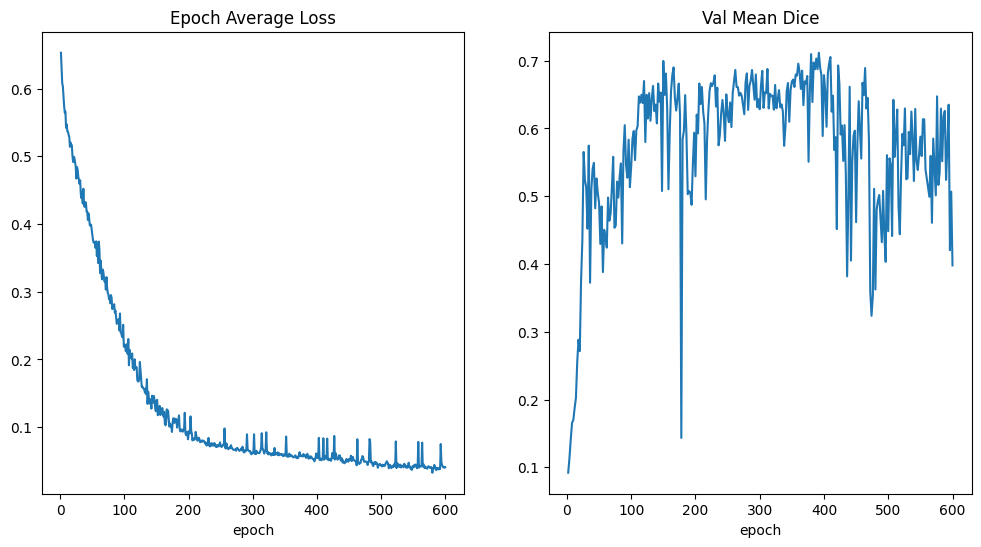

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


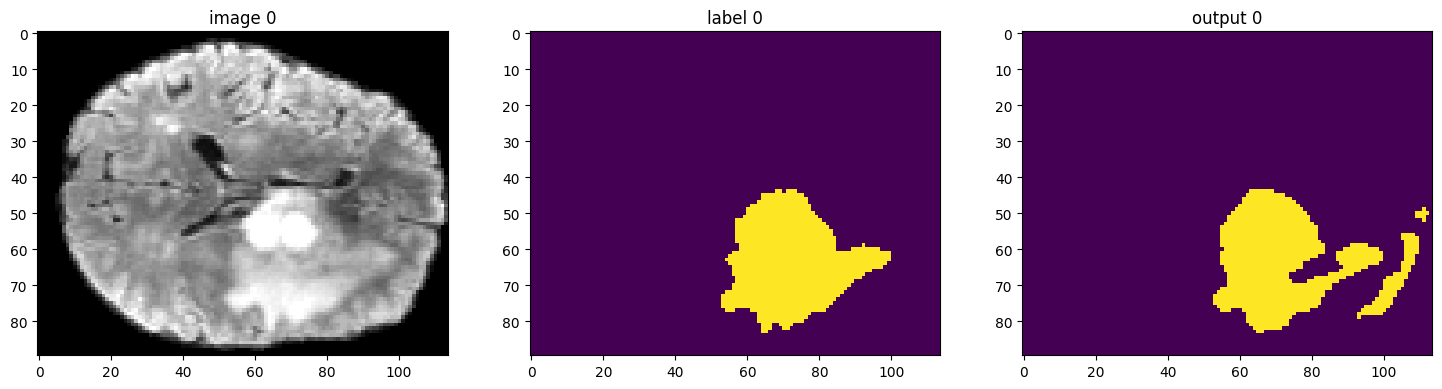

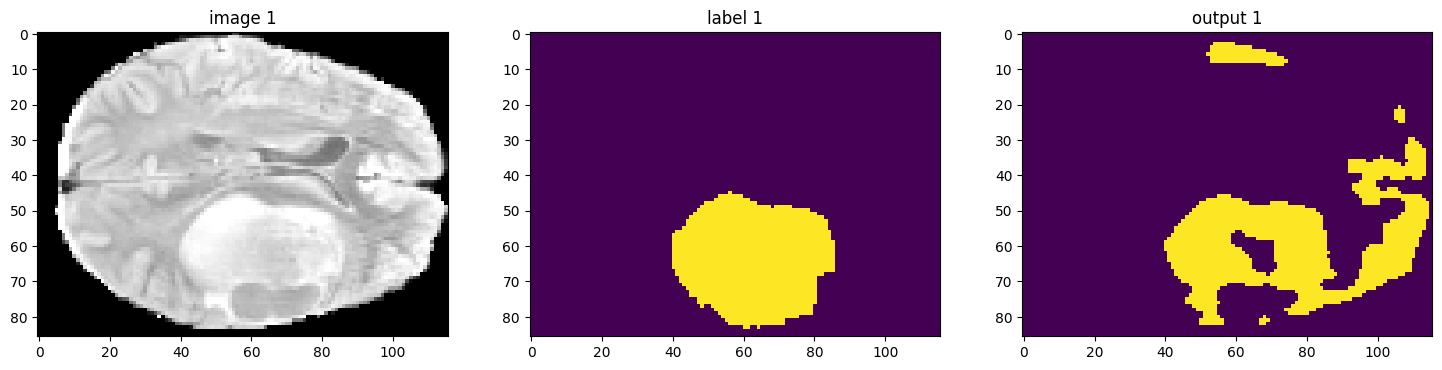

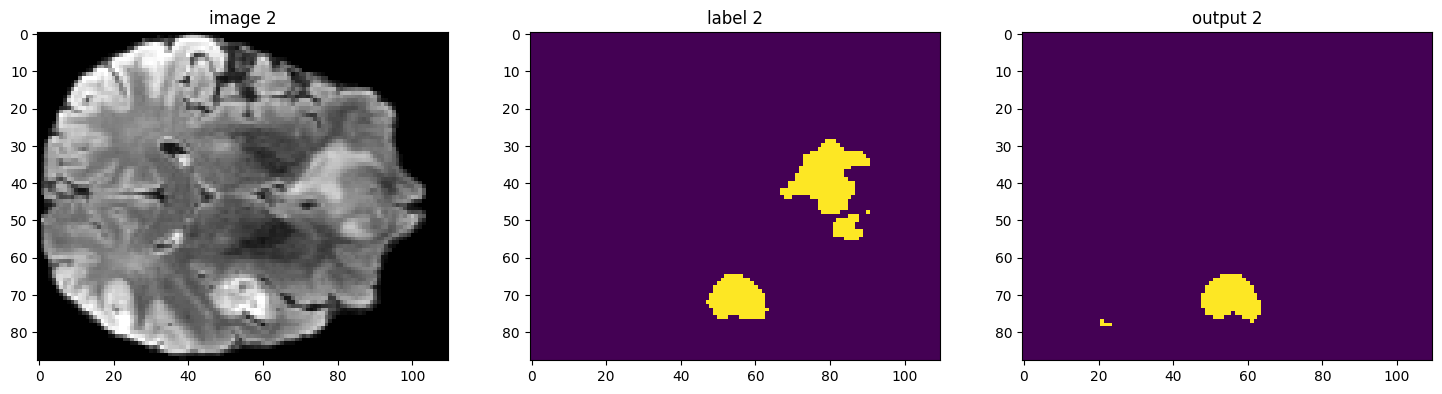

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 40
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [20]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [21]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.7122522592544556


## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)